In [14]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from matplotlib import rc
from numpy import inf

rc('text', usetex=True)

In [15]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut)
    return cutDataframe

In [26]:
def getJetData(inputFiles):
    
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    scalar.append('quark_eta')
    scalar.append('quark_theta')
    scalar.append('quark_p')
    scalar.append('quark_pt')

    cols.append('n_total')
    cols.append('jet_eta')
    cols.append('jet_theta')
    cols.append('jet_p')
    cols.append('jet_pt')
    cols.append('jet_qt')

    cols.append('dphi_e_jet')
    cols.append('dR_q_jet')
    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [17]:
def getData(inputFiles):
    
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    scalar.append('quark_eta')
    scalar.append('quark_theta')
    scalar.append('quark_p')
    scalar.append('quark_pt')
    
    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [18]:
def applyCuts(df):
    temp = df
    temp = applyCut(temp, '0.1 < y < 0.85', '0.1 < y < 0.85')
    temp = applyCut(temp, 'Q2>25', 'Q2>25')
    #temp = applyCut(temp, 'x > 0.05', 'x>0.05')
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('logx= log(x)/2.3025850', inplace=True)
    return temp

In [64]:
def applyCutsJets(df):
    temp = df
    temp = applyCut(temp, '0.1 < y < 0.85', '0.1 < y < 0.85')
    temp = applyCut(temp, 'Q2>25', 'Q2>25')
    temp = applyCut(temp, 'jet_pt>5', 'jet_pt>5')
    temp = applyCut(temp, 'dphi_e_jet > 2.74', 'dphi_e_jet>3.14159-0.4')
    #temp = applyCut(temp, 'Q2>100.0', ' Q2>100.0')
    
    temp.eval('dphi = 3.14159-dphi_e_jet', inplace=True)
    temp.eval('jet_qtnorm= jet_qt/sqrt(Q2)', inplace=True)
    temp.eval('jet_qtnormjetpt= jet_qt/sqrt(jet_pt)', inplace=True)
    temp.eval('jet_qtnormept= jet_qt/sqrt(e_pt)', inplace=True)

    df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get Data

In [20]:
df = getData(['NC_10_275.root'])
xsec = np.mean(df['xsec'])
xsec = xsec*1e9
print 'xsection %2.2f [pb]' %(xsec)
accepted = df.shape[0]
print 'accepted events' , accepted
to_cross_section = xsec/(1.0*accepted)

df = applyCuts(df)
print 'Accepted cross-section: %2.0f [pb]'%(df.shape[0]*to_cross_section)


Processed NC_10_275.root in 0.7 seconds
xsection 17649.20 [pb]
accepted events 250000
0.1 < y < 0.85 133361  fraction kept: 53.3
Q2>25 132535  fraction kept: 99.4
Accepted cross-section: 9357 [pb]


## Inclusive rate

In [21]:
##Total cross-section: 
## in units of fb:
lumi = 100 # in units of fb-1. 
integrated_rate    = 1000*lumi*xsec #multiply by 1000 and then 100 to get integrated yield for 100 fb-1
print 'Integrated rate %2.3f [M]' %(integrated_rate/1e6)

Integrated rate 1764.920 [M]


## Plot all variables in the electron beam

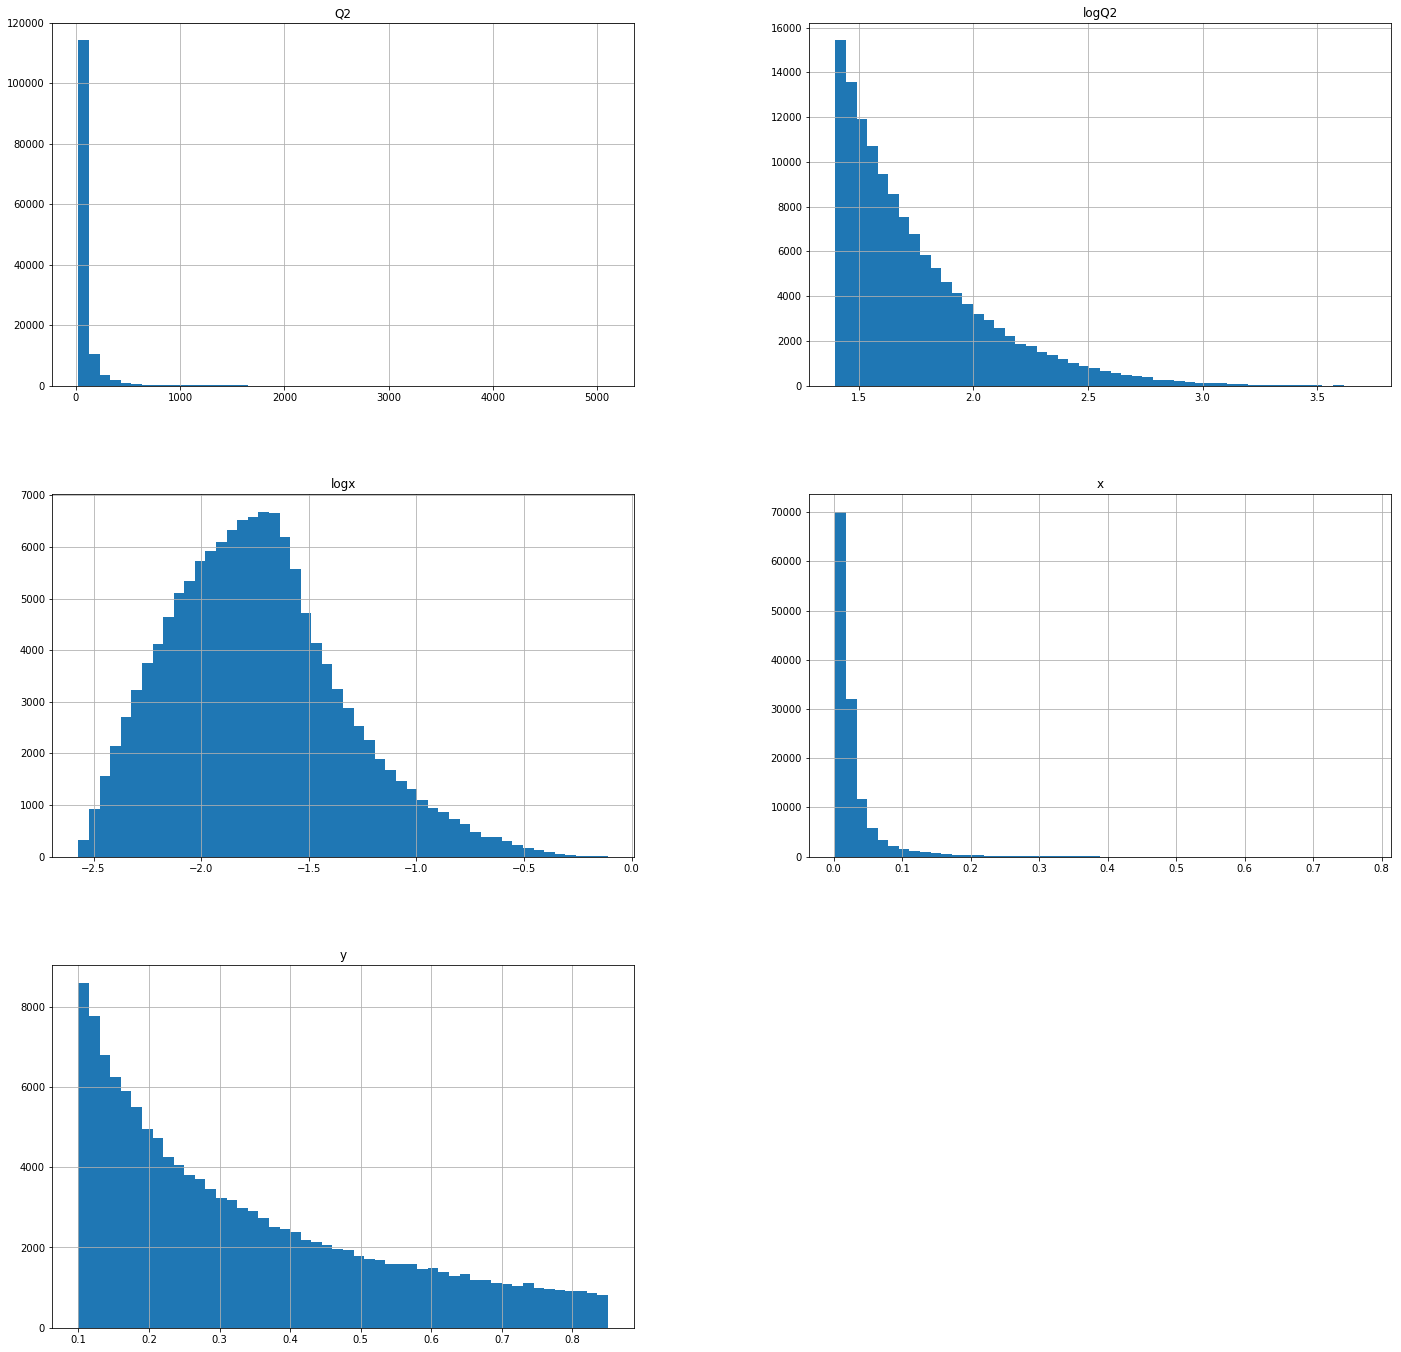

In [22]:
rc('text', usetex=False)
df.hist(figsize=(24,24),bins=50,column=['x','Q2','logx','logQ2','y'])
plt.show()

## Get jet data, apply selection

In [65]:
df_jet      = getJetData(['NC_10_275.root'])
df_jet = applyCutsJets(df_jet)


Processed NC_10_275.root in 6.6 seconds
0.1 < y < 0.85 127032  fraction kept: 47.1
Q2>25 126944  fraction kept: 99.9
jet_pt>5 126944  fraction kept: 100.0
dphi_e_jet>3.14159-0.4 67585  fraction kept: 53.2
 n>1 150550  fraction kept: 55.8


## Plot jet variables

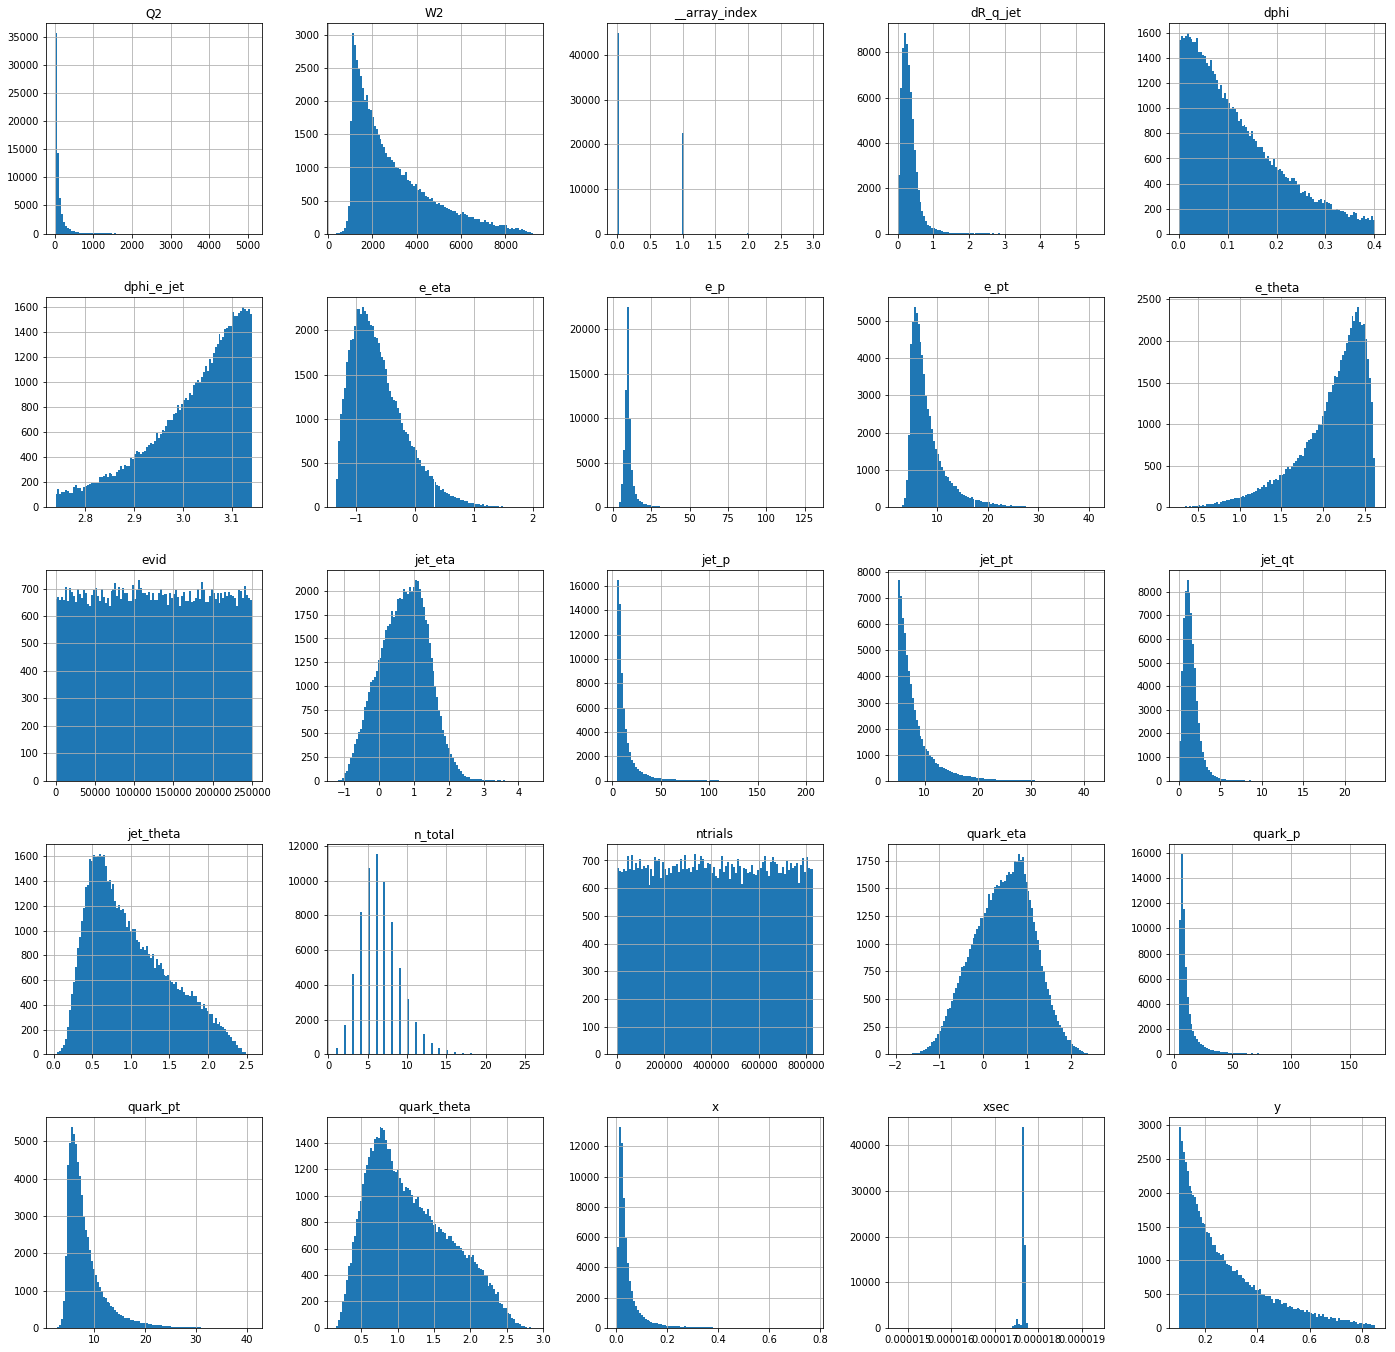

In [28]:
rc('text', usetex=False)
df_jet.hist(figsize=(24,24),bins=100)
plt.show()

## Inclusive cross-section

<Container object of 3 artists>

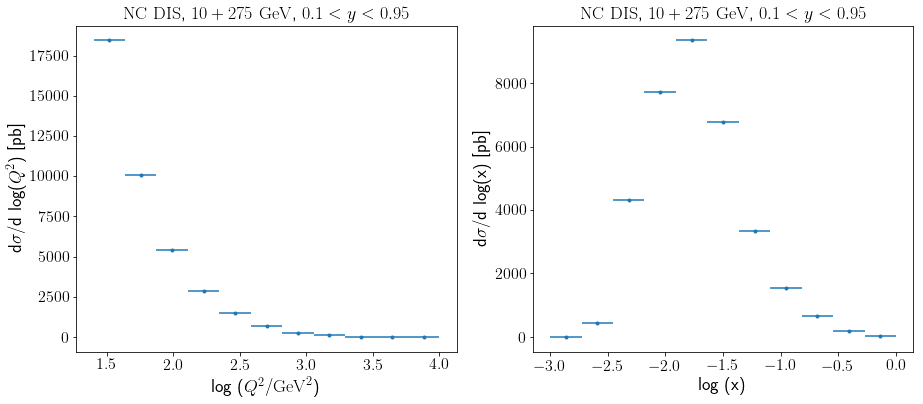

In [29]:
rc('text', usetex=True)

fig, ax1 = plt.subplots(figsize=(15,6))

##Electron distribution
plt.subplot(121)
y, x  = np.histogram(df['logQ2'],bins=np.linspace(1.4,4,12))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_cross_section
y = y/(xerr*2.0)

plt.errorbar(x,y,  xerr = xerr, fmt='.',ls='none')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('log ($Q^{2}$/$\mathrm{GeV}^{2}$)',fontsize=18)
plt.ylabel(r'd$\sigma$/d log($Q^{2}$) [pb]',fontsize=18)
plt.title('$\mathrm{NC}\ \mathrm{DIS}$, $10+275$ $\mathrm{GeV}$, $0.1<y<0.95$', fontsize=18)


plt.subplot(122)
y, x  = np.histogram(df['logx'],bins=np.linspace(-3.0,0,12))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_cross_section
y = y/(xerr*2.0)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('log (x)',fontsize=18)
plt.ylabel(r'd$\sigma$/d log(x) [pb]',fontsize=18)
plt.title('$\mathrm{NC}\ \mathrm{DIS}$, $10+275$ $\mathrm{GeV}$, $0.1<y<0.95$', fontsize=18)
plt.errorbar(x,y,  xerr = xerr, fmt='.',ls='none')

Cross section [19216478.66024899  9487476.11411019  4522516.87761174  2034723.95214605
   692634.54347226   164888.2296279     27332.70273905]


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


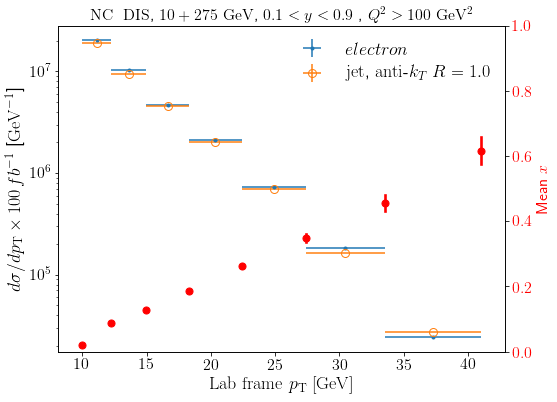

In [30]:
import seaborn as sns
nbins = 8
minpt = 10
maxpt = max(df['e_pt'])
fig, ax1 = plt.subplots(figsize=(8,6))

##Electron distribution
y, x  = np.histogram(df.query('e_pt>5')['e_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_cross_section
y = y*1000*lumi 
yerr = np.sqrt(y)

y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)

plt.errorbar(x,y, yerr=yerr,  xerr = xerr, fmt='.',ls='none',label=r'$electron$')


y, x  = np.histogram(df_jet.query('jet_pt>5')['jet_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_cross_section
y = y*1000*lumi 

yerr = np.sqrt(y)
y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)
print 'Cross section', y 
plt.errorbar(x,y, yerr=yerr,xerr = xerr, fmt='o',ls='none',markersize=8,fillstyle='none',label='$\mathrm{jet}$, $\mathrm{anti}$-$k_{T}$ $R=1.0$')

plt.yscale('log')
ax1.set_xlabel(r'$\mathrm{Lab}$\ $\mathrm{frame}$ $p_{\mathrm{T}}$ $\mathrm{[GeV]}$' ,fontsize=18)
ax1.set_ylabel(r'$d\sigma/d p_{\mathrm{T}} \times 100 \, fb^{-1}$ [$\mathrm{GeV^{-1}}$]', fontsize=18)
plt.title('$\mathrm{NC}$ \ $\mathrm{DIS}$, $10+275$\ $\mathrm{GeV}$, $0.1 < y < 0.9$ , $Q^2 > 100\ \mathrm{GeV^2}$',   fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc='best',frameon=False,fontsize=18)#bbox_to_anchor=(0.40, 0.85

###Mean x vs pT
ax2 = ax1.twinx()
ax2.tick_params(axis='y', labelcolor='red')
sns.regplot(df['e_pt'], df['x'], x_bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins),fit_reg=None,color='red')
ax2.set_ylabel('Mean $x$' ,color='red',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax2.set_ylim([0.0,1.0])
#ax2.scale('log')
plt.savefig('CrossSection_NC.png', bbox_inches='tight')
plt.savefig('CrossSection_NC.pdf', bbox_inches='tight')

plt.legend(loc='best',frameon=False,fontsize=15,bbox_to_anchor=(0.40, 0.85))

## Maximum pT

In [31]:
print max(df['e_pt'])

41.0188293457


## Sivers asymmetry for lepton-jet correlation!

In [32]:
dilution_factor =0.7 # proton polarization for single-spin asymmetries ()
efficiency = 0.5 #overall-efficiency
penalty = 1.0 #sqrt(2) coming from separating Sivers v Collins v something else
lumi = 100 # in units of fb-1. 100 is expected in a year? (check)

def fake_A(x,slope=0.05):
    return slope*np.ones(len(x))

9.571004  mean pt
9.182577  mean pt
0.054848827  mean x
138.48225  mean Q2
Number of events  98270752.58363038
###########
[ 1595487.79338365 11712009.95231629 18955242.14705802 20141268.47134321
 20296581.44238055 18510482.27545107  6819651.36463987   240029.13705772
        0.                0.                0.        ]
error [0.00159945 0.00059034 0.00046404 0.00045017 0.00044844 0.00046958
 0.00077363 0.00412368        inf        inf        inf]
[1.24577251e-02 1.85812576e-02 2.77147821e-02 4.13378450e-02
 6.16572565e-02 9.19645732e-02 1.37169300e-01 2.04594185e-01
 1.00000000e+03 1.00000000e+03 1.00000000e+03]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in divide


13.585154  mean pt
13.06296  mean pt
0.107754394  mean x
298.38367  mean Q2
Number of events  53032319.92875226
###########
[       0.            21179.04150509  3014483.57422487  8146871.29895901
 10540102.98903449 10603640.11354977 10547162.66953619  7469141.97079604
  2527365.61960774   162372.65153904        0.        ]
error [       inf 0.01388238 0.00116362 0.00070782 0.00062229 0.00062043
 0.00062208 0.00073923 0.00127082 0.00501373        inf]
[1.00000000e+03 2.85812576e-02 3.77147821e-02 5.13378450e-02
 7.16572565e-02 1.01964573e-01 1.47169300e-01 2.14594185e-01
 3.15161437e-01 4.65162018e-01 1.00000000e+03]
19.553444  mean pt
18.897236  mean pt
0.19857906  mean x
667.7166  mean Q2
Number of events  11514338.898268761
###########
[      0.               0.               0.               0.
  691848.68916636 2061426.70649569 2993304.53271978 2619141.4661298
 1955531.49897023 1087190.79726143  105895.20752546]
error [       inf        inf        inf        inf 0.00242891 0.00140

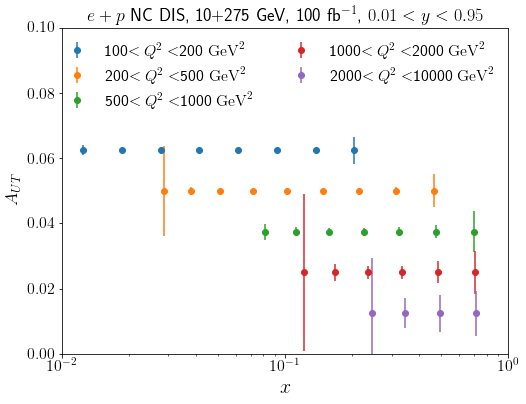

In [33]:
rc('text', usetex=True)

fig = plt.figure(figsize=(8,6))
asymmetry = [0.125,0.1,0.075,0.05,0.025]
asymmetry = np.divide(asymmetry,2.0)
#colores = ['black','blue','red','purple']



for counter,edges in enumerate([(100,200),(200,500), (500,1000),(1000,2000), (2000,10000)]):
    df_cut = df_jet.query('dphi<0.4 and Q2 > %2.2f and Q2<%2.2f'%(edges[0],edges[1]))
    print df_cut['e_pt'].mean(), ' mean pt'
    print df_cut['jet_pt'].mean(), ' mean pt'

    print df_cut['x'].mean(), ' mean x'
    print df_cut['Q2'].mean(), ' mean Q2'
    
    print 'Number of events ', df_cut.shape[0]*to_cross_section*1000*lumi 
    
    print '###########'
    y, x  = np.histogram(df_cut['x'],bins=np.logspace(-2,-0.09,12))
    x = (x[1:]+x[:-1])/2
    x = x + 0.01*counter
    #y[y<100] = 0
    #print y
    y = y*to_cross_section
    y = y*1000*lumi
    print y 
    
    y = y*efficiency # take efficiency hit
    erry = np.divide(1,dilution_factor*np.sqrt(y),out=np.zeros_like(y)) #follow standard formula for asymmetry uncertainty
    print 'error', erry
    x[erry == inf] = 1000
    print x
    plt.errorbar(x,y=fake_A(x,asymmetry[counter]) , yerr=erry, fmt='o',ls='none',label='%2.0f$<Q^{2}<$%2.0f $\mathrm{GeV}^{2}$'%(edges[0],edges[1]))
    #print 'error', erry
    #print x
    
    #plt.errorbar(x,y,label='%2.0f$<Q^{2}<$%2.0f'%(edges[0],edges[1]))

    #plt.errorbar(x,y,label='%2.2f$<x<$%2.2f'%(edges[0],edges[1]))
####
plt.ylim([0.0,0.10])
plt.xlim([0.01,1.0])
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.yscale('log')

plt.xscale('log')
plt.title('$e+p$ NC DIS, 10+275 GeV, 100 fb$^{-1}$, $0.01<y<0.95$', fontsize=18)
plt.legend(loc='best', fontsize=16,frameon=False,ncol=2)
plt.ylabel('$A_{UT}$',fontsize=18)
plt.xlabel('$x$',fontsize=20)
plt.savefig('AUT_NC_Sivers_xdependence.png', bbox_inches='tight')
plt.savefig('AUT_Sivers_xdependence.pdf', bbox_inches='tight')

10.61899  mean pt
0.0689971  mean x
171.57558  mean Q2
 
16.803944  mean pt
0.17147884  mean x
433.25153  mean Q2
 
19.803577  mean pt
0.24117827  mean x
595.77893  mean Q2
 
24.833908  mean pt
0.38589984  mean x
936.733  mean Q2
 


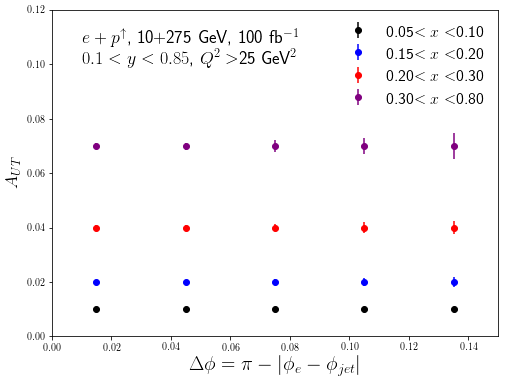

In [34]:
fig = plt.figure(figsize=(8,6))
asymmetry = [0.01,0.02,0.04,0.07]
colores = ['black','blue','red','purple']
for counter,edges in enumerate([(0.05,0.1), (0.15,0.2),(0.2,0.3),(0.3,0.8)]):
    maxdphi = 0.15
    df_cut = df_jet.query('x > %2.2f and x<%2.2f'%(edges[0],edges[1]))
    print df_cut['e_pt'].mean(), ' mean pt'
    print df_cut['x'].mean(), ' mean x'
    print df_cut['Q2'].mean(), ' mean Q2'

    y, x  = np.histogram(df_cut['dphi'],bins=5,range=(0.0,maxdphi))
    x = (x[1:]+x[:-1])/2
    y = y*to_cross_section
    y = y*1000*lumi
    erry = 1/(dilution_factor*np.sqrt(y)) #follow standard formula for asymmetry uncertainty
    erry= penalty*erry #take sqrt(2) because of interference with other modulations
    plt.errorbar(x,y=fake_A(x,asymmetry[counter]) , yerr=erry, fmt='o',ls='none',color=colores[counter],label='%2.2f$<x<$%2.2f'%(edges[0],edges[1]))
    print ' '
####
plt.ylim([0.0,0.12])
plt.xlim([0.0,0.15])

plt.text(0.01, 0.1, '$e+p^{\uparrow}$, 10+275 GeV, 100 fb$^{-1}$ \n $0.1<y<0.85$, $Q^{2}>$25 GeV$^{2}$', fontsize=18)
plt.legend(loc='best', fontsize=16,frameon=False,ncol=1)
plt.ylabel('$A_{UT}$',fontsize=18)
plt.xlabel('$\Delta\phi = \pi-|\phi_{e}-\phi_{jet}|$',fontsize=20)
plt.savefig('AUT_Sivers_xbins.png', bbox_inches='tight')
plt.savefig('AUT_Sivers_xbins.pdf', bbox_inches='tight')

6.9087296  mean pt
9.895667  mean pt
14.657087  mean pt


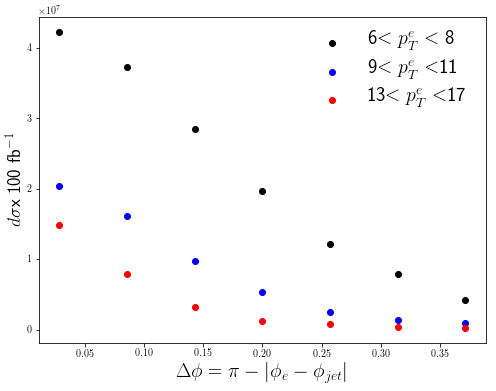

In [35]:
fig = plt.figure(figsize=(8,6))
asymmetry = [0.01,0.02,0.04]
colores = ['black','blue','red']
for counter,edges in enumerate([(6.0,8.0), (9,11),(13.0,17.0)]):
    maxdphi = np.pi
    df_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    print df_cut['e_pt'].mean(), ' mean pt'
    y, x  = np.histogram(df_cut['dphi'],bins=7,range=(0.0,0.4))
    x = (x[1:]+x[:-1])/2
    y = y*to_cross_section
    y = y*1000*lumi
    erry = np.sqrt(y)
    plt.errorbar(x,y ,fmt='o',ls='none',color=colores[counter],label='%2.0f$<p_{T}^{e}<$%2.0f'%(edges[0],edges[1]))

####
plt.legend(frameon=False,loc='best')
#plt.ylim([0.0,0.07])

#plt.text(0.01, 0.05, '$e+p^{\uparrow}$, 18+100 GeV \n $0.1<y<0.85$, $Q^{2}>$25 GeV$^{2}$\n 100 fb$^{-1}$', fontsize=18)
plt.legend(loc='best', fontsize=20,frameon=False)
plt.ylabel('$d\sigma $x 100 fb$^{-1}$',fontsize=18)
plt.xlabel('$\Delta\phi = \pi-|\phi_{e}-\phi_{jet}|$',fontsize=20)
plt.savefig('AUT_Sivers_distributions.png', bbox_inches='tight')
plt.savefig('AUT_Sivers_distributions.pdf', bbox_inches='tight')

6.9087296  mean pt
0.028018111
71.69661  mean Q2
 
9.895667  mean pt
0.057490233
146.54196  mean Q2
 
14.657087  mean pt
0.12377159
326.87537  mean Q2
 


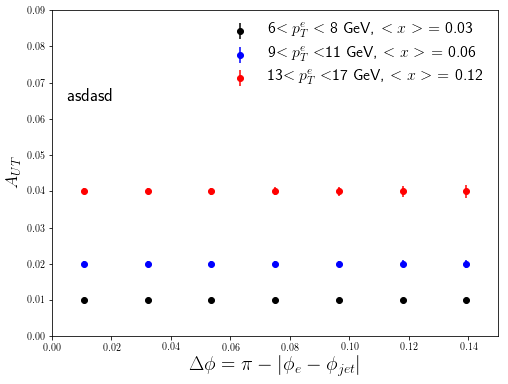

In [37]:
fig = plt.figure(figsize=(8,6))
asymmetry = [0.01,0.02,0.04,0.06]
colores = ['black','blue','red','purple']
for counter,edges in enumerate([(6.0,8.0), (9,11),(13.0,17.0)]):
    maxdphi = 0.15
    df_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    print df_cut['e_pt'].mean(), ' mean pt'
    mean_x = df_cut['x'].mean()
    print mean_x
    
    print df_cut['Q2'].mean(), ' mean Q2'

    y, x  = np.histogram(df_cut['dphi'],bins=7,range=(0.0,maxdphi))
    x = (x[1:]+x[:-1])/2
    y = y*to_cross_section
    y = y*1000*lumi
    y = y*efficiency # take efficiency hit
    erry = 1/(dilution_factor*np.sqrt(y)) #follow standard formula for asymmetry uncertainty
    erry= penalty*erry #take sqrt(2) because of interference with other modulations
    plt.errorbar(x,y=fake_A(x,asymmetry[counter]) , yerr=erry, fmt='o',ls='none', color=colores[counter],label='%2.0f$<p_{T}^{e}<$%2.0f GeV, $<x>$ = %2.2f'%(edges[0],edges[1],mean_x))
    print ' '
####
plt.legend(frameon=False,loc='best',ncol=2,fontsize=16)
plt.ylim([0.0,0.09])
#plt.ylim([-0.15,0.15])

plt.xlim([0.0,0.15])

plt.text(0.005, 0.065, 'asdasd', fontsize=18)
plt.legend(loc='best', fontsize=16,frameon=False)
plt.ylabel('$A_{UT}$',fontsize=18)
plt.xlabel('$\Delta\phi = \pi-|\phi_{e}-\phi_{jet}|$',fontsize=20)
plt.savefig('AUT_Sivers.png', bbox_inches='tight')
plt.savefig('AUT_Sivers.pdf', bbox_inches='tight')

###########
###########
###########


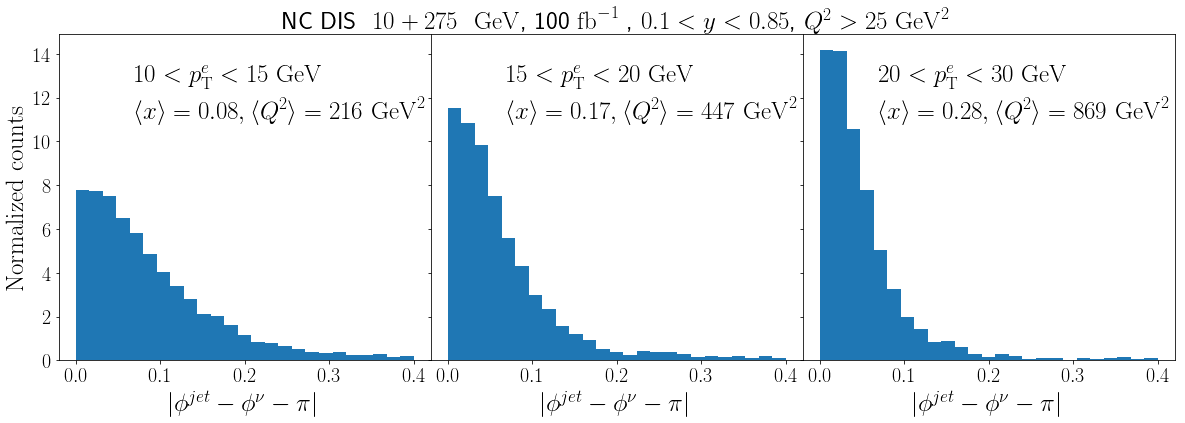

In [63]:
from matplotlib import rc
rc('text', usetex=True)


fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})


for counter,edges in enumerate([(10,15), (15,20),(20,30)]):

    df_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    #printSummary(df_cut)
    print '###########'
    
    axs[counter].hist(df_cut['dphi'],bins=25,range=(0,0.4),normed=True)
    
    axs[counter].xaxis.set_label_text(r'$|\phi^{jet}-\phi^\nu-\pi|$', fontsize=25)
    axs[0].yaxis.set_label_text(r'$\mathrm{Normalized\ counts}$', fontsize=25)
    axs[counter].tick_params('both',labelsize=20)
    plt.yticks(fontsize=20)
    #axs[counter].text(0.1,6, , fontsize=20)
    #axs[counter].text(0.1,8, '$\sqrt{s} = 89 \, \mathrm{GeV}$ \n $0.1 < y < 0.85$ \n $p_T^{jet} > 4 \, \mathrm{GeV/c}$', fontsize=20)
    #plt.legend(prop={'size': 20}, frameon=False, loc='best')
    axs[counter].text(0.07,11, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$ \n' +
                      r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=25)

axs[1].set_title(r'NC\ DIS \ $10+275$ \ $\mathrm{GeV}$, 100 $\mathrm{fb}^{-1}$ , $0.1<y<0.85$, $Q^{2}>25$ $\mathrm{GeV}^{2}$',fontsize=25)  

plt.savefig('NC_LeptonJetAzimuthal.png', bbox_inches='tight')
plt.savefig('NC_LeptonJetAzimuthal.pdf', bbox_inches='tight')


## qT distirbutions

###########
###########
###########


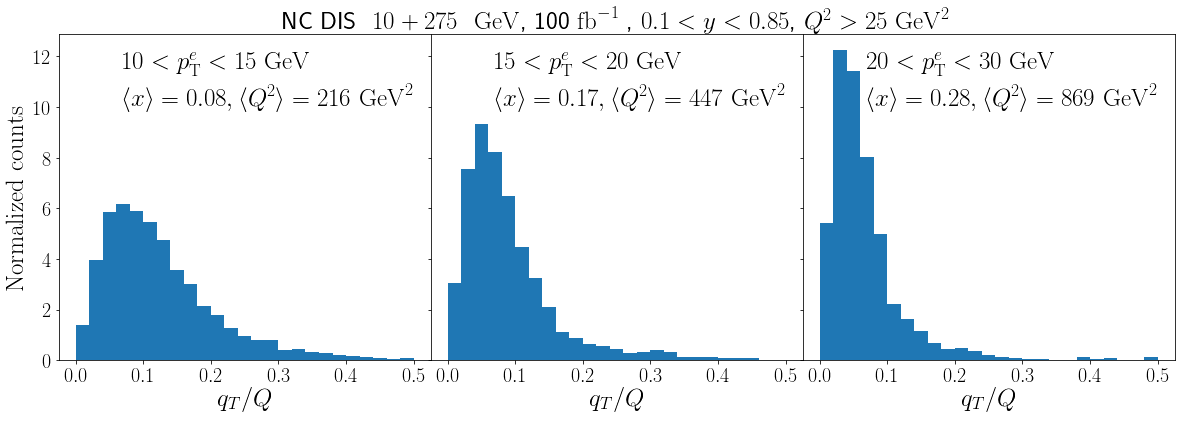

In [62]:
from matplotlib import rc
rc('text', usetex=True)


fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})


for counter,edges in enumerate([(10,15), (15,20),(20,30)]):

    df_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    #printSummary(df_cut)
    print '###########'
    
    axs[counter].hist(df_cut['jet_qtnorm'],bins=25,range=(0,0.5),normed=True)
    
    axs[counter].xaxis.set_label_text(r'$q_{T}/Q$', fontsize=25)
    axs[0].yaxis.set_label_text(r'$\mathrm{Normalized\ counts}$', fontsize=25)
    axs[counter].tick_params('both',labelsize=20)
    plt.yticks(fontsize=20)
    #axs[counter].text(0.1,6, , fontsize=20)
    #axs[counter].text(0.1,8, '$\sqrt{s} = 89 \, \mathrm{GeV}$ \n $0.1 < y < 0.85$ \n $p_T^{jet} > 4 \, \mathrm{GeV/c}$', fontsize=20)
    #plt.legend(prop={'size': 20}, frameon=False, loc='best')
    axs[counter].text(0.07,10, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$ \n' +
                      r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=25)

axs[1].set_title(r'NC\ DIS \ $10+275$ \ $\mathrm{GeV}$, 100 $\mathrm{fb}^{-1}$ , $0.1<y<0.85$, $Q^{2}>25$ $\mathrm{GeV}^{2}$',fontsize=25)  

plt.savefig('NC_LeptonJetqt.png', bbox_inches='tight')
plt.savefig('NC_LeptonJetqt.pdf', bbox_inches='tight')


###########
###########
###########


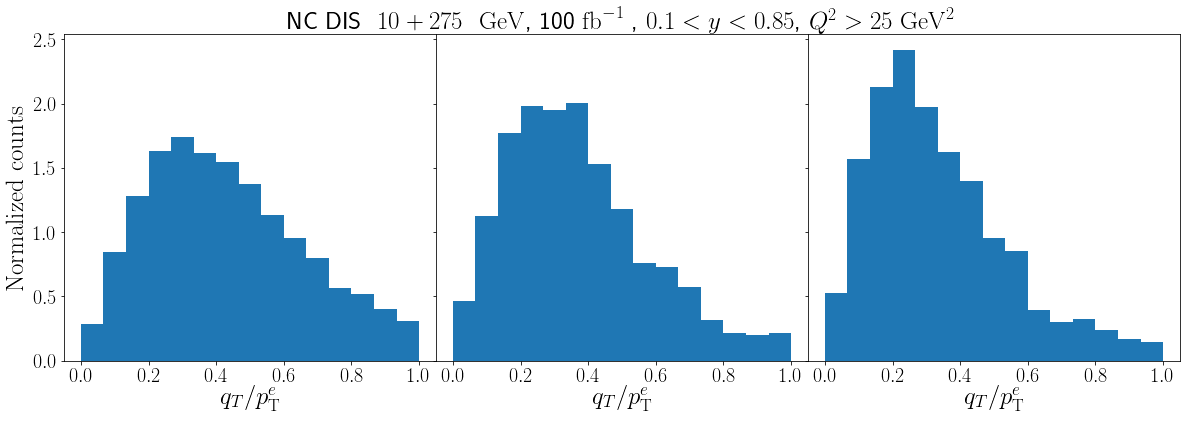

In [74]:
from matplotlib import rc
rc('text', usetex=True)


fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})


for counter,edges in enumerate([(10,15), (15,20),(20,30)]):

    df_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    #printSummary(df_cut)
    print '###########'
    
    axs[counter].hist(df_cut['jet_qtnormept'],bins=15,range=(0,1.0),normed=True)
    
    axs[counter].xaxis.set_label_text(r'$q_{T}/p_{\mathrm{T}}^{e}$', fontsize=25)
    axs[0].yaxis.set_label_text(r'$\mathrm{Normalized\ counts}$', fontsize=25)
    axs[counter].tick_params('both',labelsize=20)
    plt.yticks(fontsize=20)
    #axs[counter].text(0.1,6, , fontsize=20)
    #axs[counter].text(0.1,8, '$\sqrt{s} = 89 \, \mathrm{GeV}$ \n $0.1 < y < 0.85$ \n $p_T^{jet} > 4 \, \mathrm{GeV/c}$', fontsize=20)
    #plt.legend(prop={'size': 20}, frameon=False, loc='best')
    #axs[counter].text(0.07,10, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$ \n' +
    #                  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=25)

axs[1].set_title(r'NC\ DIS \ $10+275$ \ $\mathrm{GeV}$, 100 $\mathrm{fb}^{-1}$ , $0.1<y<0.85$, $Q^{2}>25$ $\mathrm{GeV}^{2}$',fontsize=25)  

plt.savefig('NC_LeptonJetqtoverept.png', bbox_inches='tight')
plt.savefig('NC_LeptonJetqtoverept.pdf', bbox_inches='tight')

###########
###########
###########


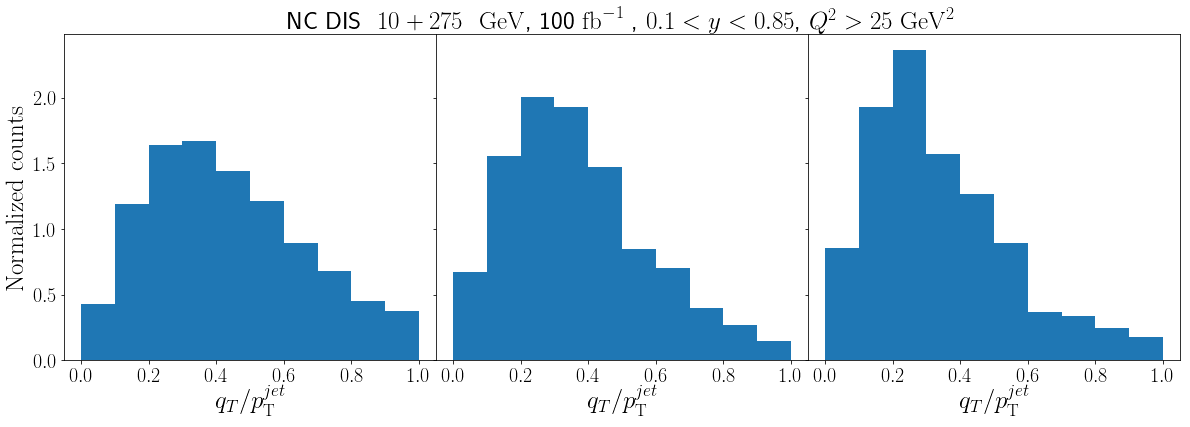

In [73]:
from matplotlib import rc
rc('text', usetex=True)


fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})


for counter,edges in enumerate([(10,15), (15,20),(20,30)]):

    df_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    #printSummary(df_cut)
    print '###########'
    
    axs[counter].hist(df_cut['jet_qtnormjetpt'],bins=10,range=(0,1.0),normed=True)
    
    axs[counter].xaxis.set_label_text(r'$q_{T}/p_{\mathrm{T}}^{jet}$', fontsize=25)
    axs[0].yaxis.set_label_text(r'$\mathrm{Normalized\ counts}$', fontsize=25)
    axs[counter].tick_params('both',labelsize=20)
    plt.yticks(fontsize=20)
    #axs[counter].text(0.1,6, , fontsize=20)
    #axs[counter].text(0.1,8, '$\sqrt{s} = 89 \, \mathrm{GeV}$ \n $0.1 < y < 0.85$ \n $p_T^{jet} > 4 \, \mathrm{GeV/c}$', fontsize=20)
    #plt.legend(prop={'size': 20}, frameon=False, loc='best')
    #axs[counter].text(0.07,10, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$ \n' +
    #                  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=25)

axs[1].set_title(r'NC\ DIS \ $10+275$ \ $\mathrm{GeV}$, 100 $\mathrm{fb}^{-1}$ , $0.1<y<0.85$, $Q^{2}>25$ $\mathrm{GeV}^{2}$',fontsize=25)  

plt.savefig('NC_LeptonJetqtoverept.png', bbox_inches='tight')
plt.savefig('NC_LeptonJetqtoverept.pdf', bbox_inches='tight')